## Image Classfier 

### Author: Michelangelo Zampieri

Data from kaggle [link](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)

In [44]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.image as mpimg


## Spliting the data

The data from the kaggle link is divided into one directory with 4 sub directories within it for each class. 

I will split the data into 3 sudirectories, train, validation, and test. Each subdirectory will be split into 4 subdirectory one per class.

Here I define and create the directories and define the classes

In [45]:
data_dir = "/Users/michelangelozampieri/Desktop/image_classifier/data"
output_dir = "/Users/michelangelozampieri/Desktop/image_classifier/data_output"

train_dir = os.path.join(output_dir, "train")
validation_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ["cloudy", "desert", "green_area", "water" ]


Here the subdirectories for each class is created and some images from the train directory are added to the others using the `train_test`split` method.

In [46]:
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)

    train_val_images, test_images = train_test_split(images, test_size=0.15, random_state=42)
    train_images, validation_images = train_test_split(train_val_images, test_size=0.1765, random_state=42)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    for image in train_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(train_dir, class_name, image))
    for image in validation_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(validation_dir, class_name, image))
    for image in test_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(test_dir, class_name, image))

Making sure the ocrrect structure and number of images is achived

In [47]:
print("Number of images in training directory:")
for class_name in classes:
    print(f"{class_name}: {len(os.listdir(os.path.join(train_dir, class_name)))}")
print("Number of images in validation directory:")
for class_name in classes:
    print(f"{class_name}: {len(os.listdir(os.path.join(test_dir, class_name)))}")
print("Number of images in test directory:")
for class_name in classes:
    print(f"{class_name}: {len(os.listdir(os.path.join(validation_dir, class_name)))}")

Number of images in training directory:
cloudy: 1221
desert: 919
green_area: 1221
water: 1221
Number of images in validation directory:
cloudy: 300
desert: 227
green_area: 300
water: 300
Number of images in test directory:
cloudy: 426
desert: 313
green_area: 426
water: 426


## Plotting random images

First I plot some of the images from any of the classes to get a sense of the data

In [48]:
def plot_images(class_name):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)
    random_images = random.sample(images, 3)
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(random_images):
        plt.subplot(1, 3, i+1)
        img = mpimg.imread(os.path.join(class_dir, image))
        plt.imshow(img)
        plt.axis("off")
    plt.show()

Images for class cloudy in training directory:


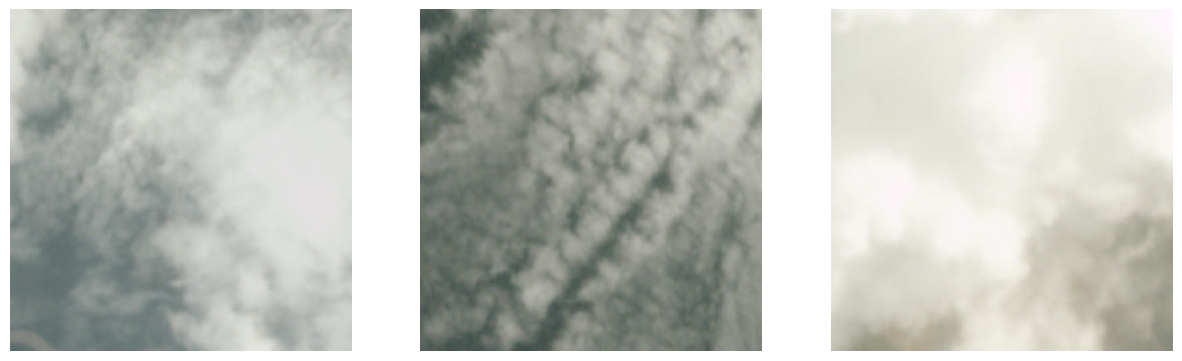

Images for class desert in training directory:


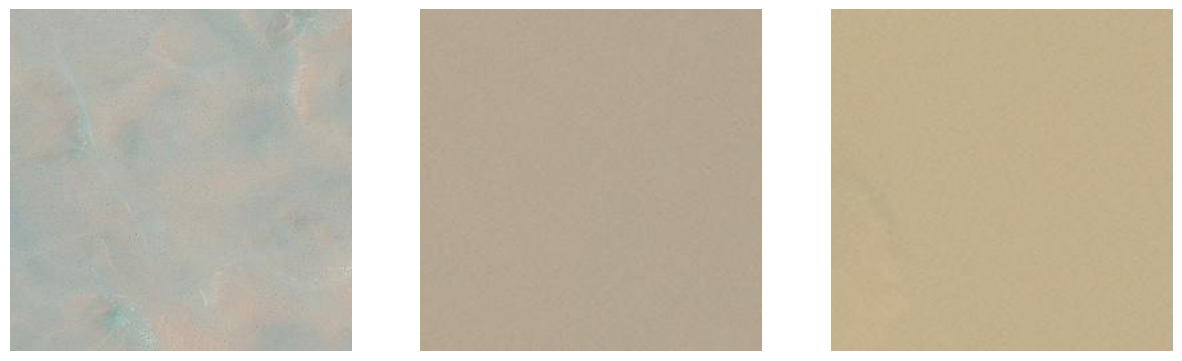

Images for class green_area in training directory:


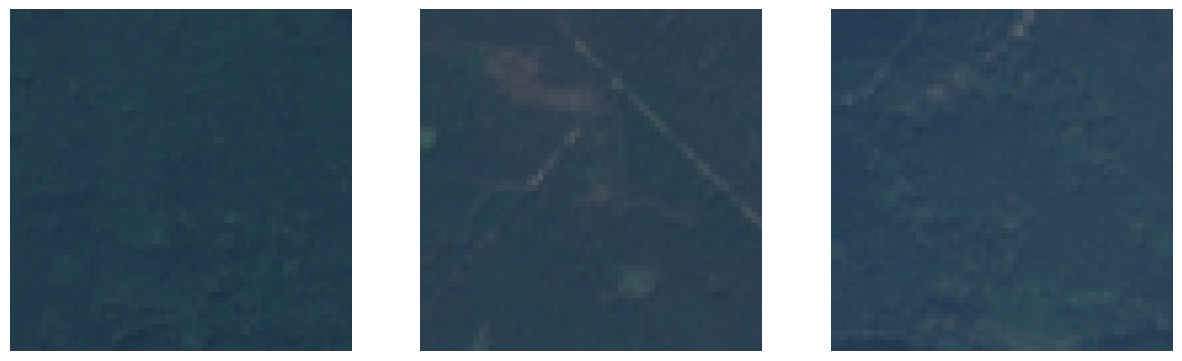

Images for class water in training directory:


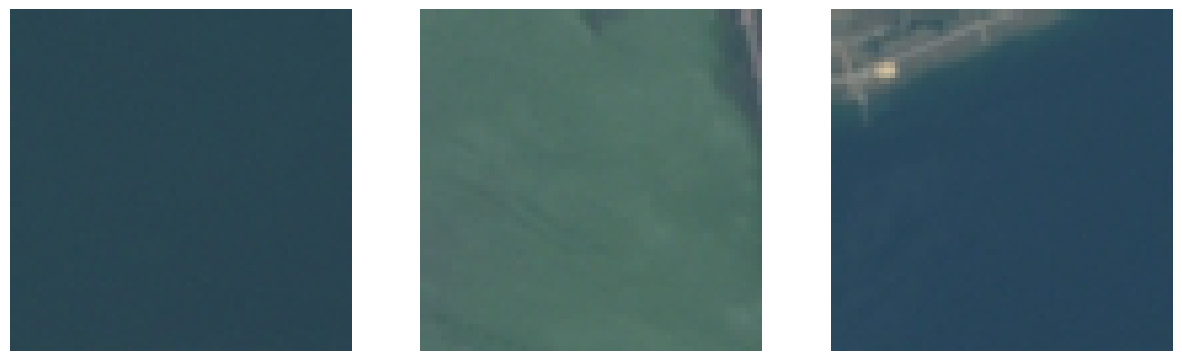

In [49]:
for c in classes:
    print (f"Images for class {c} in training directory:")
    plot_images(c)

## Defining data sets

Training and validation datasets are created in order to create the model.

`train_datagen` also performs some data augmentation

In [50]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical"
)

Found 4582 images belonging to 4 classes.


In [51]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical"
)

Found 1591 images belonging to 4 classes.


## Training the model

The first CNN I wanted to explore was one I built from scratch, I decided to use ReLU as the activation function for simplicity, and kept the input shape to (150 x 150 x 3) (standard for color images).

The model has the following layers:
1. 4 sets of convolutional and pooling layers intertwined 
2. Flatten layer to get a 1D vector
3. Dense layer
4. Output layer

In [52]:
model = tf.keras.models.Sequential([
    # First convolutional layer with 32 filters, 3x3 kernel size, ReLU activation, and input shape of 150x150x3
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    # First max pooling layer with a 2x2 pool size
    tf.keras.layers.MaxPooling2D(2, 2),
    # Second convolutional layer with 64 filters and 3x3 kernel size
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    # Second max pooling layer with a 2x2 pool size
    tf.keras.layers.MaxPooling2D(2, 2),
    # Third convolutional layer with 128 filters and 3x3 kernel size
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    # Third max pooling layer with a 2x2 pool size
    tf.keras.layers.MaxPooling2D(2, 2),
    # Fourth convolutional layer with 128 filters and 3x3 kernel size
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    # Fourth max pooling layer with a 2x2 pool size
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten layer to convert 3D feature maps to 1D feature vectors
    tf.keras.layers.Flatten(),
    # Fully connected dense layer with 512 units and ReLU activation
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # Output dense layer with 4 units (one for each class) and softmax activation
    tf.keras.layers.Dense(4, activation="softmax")
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compile and Train

Decided to keep simple loss and optimzer with only 10 epochs

In [53]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='rmsprop',
    metrics=["accuracy"]
)

In [54]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(-epoch / 10))

In [55]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[lr_schedule]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 264ms/step - accuracy: 0.5251 - loss: 8.2972 - val_accuracy: 0.7894 - val_loss: 3.9705 - learning_rate: 1.0000e-04
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 260ms/step - accuracy: 0.7565 - loss: 3.3264 - val_accuracy: 0.8246 - val_loss: 1.9972 - learning_rate: 7.9433e-05
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 269ms/step - accuracy: 0.8246 - loss: 1.7894 - val_accuracy: 0.8668 - val_loss: 1.2843 - learning_rate: 6.3096e-05
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.8410 - loss: 1.2374 - val_accuracy: 0.8718 - val_loss: 1.0102 - learning_rate: 5.0119e-05
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 275ms/step - accuracy: 0.8586 - loss: 0.9722 - val_accuracy: 0.8693 - val_loss: 0.8756 - learning_rate: 3.9811e-05
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 279ms/step - accuracy: 0.8676 - loss: 0.8543 - val_accuracy: 0.8171 - val_loss: 0.8424 - learning_rate: 3.1623e-05
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 27

After building the model from scratch there is an initial traning accuracy of 86% and validation accuracy of .92%.

## Save model

In [56]:
os.makedirs("/Users/michelangelozampieri/Desktop/image_classifier/models", exist_ok=True)
model.save("initial_from_scratch_model.h5")

## Make predictions

In [57]:
def get_random_images(test_dir, num_images=5):
    random_images = []
    class_names = os.listdir(test_dir)
    for _ in range(num_images):
        random_class = random.choice(class_names)
        class_dir = os.path.join(test_dir, random_class)
        random_image = random.choice(os.listdir(class_dir))
        random_images.append((os.path.join(class_dir, random_image), random_class))
    return random_images


In [58]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array #type: ignore

def predict_random_images(model, test_dir, num_images=5):
    random_images = get_random_images(test_dir, num_images)
    for img_path, true_class in random_images:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0  # Normalize the image
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        
        # Print results
        # plt.imshow(img)
        # plt.axis("off")
        # plt.title(f"True: {true_class}, Predicted: {classes[predicted_class]}")
        # plt.show()
        return true_class, classes[predicted_class]


In [59]:
predict_random_images(model, test_dir, num_images=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


('cloudy', 'cloudy')

In [60]:
def evaluate_model(model, test_dir, num_images=1000):
    correct = 0
    for _ in range(num_images):
        true_class, predicted_class = predict_random_images(model, test_dir)
        if true_class == predicted_class:
            correct += 1
    return correct / num_images

In [61]:
print(evaluate_model(model, test_dir, num_images=1000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

With 1000 images it correctly identifies 91% of them